<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width = 400>

In [1]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

All libraries imported.


### Data Retrieval

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai')[-1]
df.rename(columns={'Area': 'Neighborhood'}, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


### Data Wrangling

In [3]:
df['Location'].value_counts()

South Mumbai                       30
Andheri,Western Suburbs             9
Western Suburbs                     5
Eastern Suburbs                     4
Mira-Bhayandar,Western Suburbs      3
Powai,Eastern Suburbs               3
Ghatkopar,Eastern Suburbs           3
Kandivali West,Western Suburbs      3
Bandra,Western Suburbs              3
Kalbadevi,South Mumbai              2
Vasai,Western Suburbs               2
Borivali (West),Western Suburbs     2
Mumbai                              2
Goregaon,Western Suburbs            2
Khar,Western Suburbs                2
Malad,Western Suburbs               2
Harbour Suburbs                     2
Kandivali East,Western Suburbs      1
Govandi,Harbour Suburbs             1
Colaba,South Mumbai                 1
Sanctacruz,Western Suburbs          1
Mulund,Eastern Suburbs              1
Tardeo,South Mumbai                 1
Dadar,South Mumbai                  1
Kurla,Eastern Suburbs               1
Fort,South Mumbai                   1
Antop Hill,S

In [4]:
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1])
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,Chakala,Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.098889,72.867222
7,Seven Bungalows,Western Suburbs,19.129052,72.817018
8,Versova,Western Suburbs,19.120000,72.820000
9,Mira Road,Western Suburbs,19.284167,72.871111


In [5]:
df

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,Chakala,Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,South Mumbai,18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850



Although the data we gathered contained latitude and longitude information, we can reconfirm these coordinates using Geocoder.

In [6]:
df['Latitude1'] = None
df['Longitude1'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Mumbai, India'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1
0,Amboli,Western Suburbs,19.129300,72.843400,19.1291,72.8464
1,Chakala,Western Suburbs,19.111388,72.860833,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.1251,72.8325
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.1264,72.8242
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.1432,72.825
5,Marol,Western Suburbs,19.119219,72.882743,19.1191,72.8828
6,Sahar,Western Suburbs,19.098889,72.867222,19.1054,72.8606
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.1286,72.8214
8,Versova,Western Suburbs,19.120000,72.820000,19.1377,72.8135
9,Mira Road,Western Suburbs,19.284167,72.871111,19.2656,72.8706



We can create new columns to see the difference between coordinate values obtained from wikipedia and those obtained from geocoder. We will take the absolute difference between these values and store them in our dataframe.

In [7]:
df['Latdiff'] = abs(df['Latitude'] - df['Latitude1'])
df['Longdiff'] = abs(df['Longitude'] - df['Longitude1'])
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.129300,72.843400,19.1291,72.8464,0.00024,0.00304
1,Chakala,Western Suburbs,19.111388,72.860833,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.1432,72.825,0.012395,0.0043
5,Marol,Western Suburbs,19.119219,72.882743,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.098889,72.867222,19.1054,72.8606,0.00655566,0.00662028
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.1286,72.8214,0.000472,0.004392
8,Versova,Western Suburbs,19.120000,72.820000,19.1377,72.8135,0.01769,0.00652
9,Mira Road,Western Suburbs,19.284167,72.871111,19.2656,72.8706,0.0185438,0.000467611




We can see that the latitude and longitudes from wikipedia and geocoder are very similar, yet there are some differences. We will replace the values with the coordinates obtained from geocoder if the absolute difference is more than 0.001.

In [8]:
df.loc[df.Latdiff>0.001, 'Latitude'] = df.loc[df.Latdiff>0.001, 'Latitude1']
df.loc[df.Longdiff>0.001, 'Longitude'] = df.loc[df.Longdiff>0.001, 'Longitude1']
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0.00304
1,Chakala,Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.1432,72.825,19.1432,72.825,0.012395,0.0043
5,Marol,Western Suburbs,19.1192,72.8827,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.1054,72.8606,19.1054,72.8606,0.00655566,0.00662028
7,Seven Bungalows,Western Suburbs,19.1291,72.8214,19.1286,72.8214,0.000472,0.004392
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135,0.01769,0.00652
9,Mira Road,Western Suburbs,19.2656,72.8711,19.2656,72.8706,0.0185438,0.000467611


In [9]:
df.where(df['Latitude']==df['Latitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chakala,Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.1432,72.825,19.1432,72.825,0.012395,0.0043
...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.9957,72.84,18.9957,72.8391,0.00568,0.00088
89,Gowalia Tank,South Mumbai,18.9645,72.8112,18.9645,72.8112,0.00201,0.001467
90,Dava Bazaar,South Mumbai,19.1314,72.927,19.1314,72.927,0.184518,0.095598
91,Dharavi,Mumbai,19.0467,72.8546,19.0467,72.8546,0.006532,0.00376



We can do the same for the Longitude column.

In [10]:
df.where(df['Longitude']==df['Longitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0.00304
1,Chakala,Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.1264,72.8242,19.1264,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.1432,72.825,19.1432,72.825,0.012395,0.0043
...,...,...,...,...,...,...,...,...
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Gowalia Tank,South Mumbai,18.9645,72.8112,18.9645,72.8112,0.00201,0.001467
90,Dava Bazaar,South Mumbai,19.1314,72.927,19.1314,72.927,0.184518,0.095598
91,Dharavi,Mumbai,19.0467,72.8546,19.0467,72.8546,0.006532,0.00376




Now that we have the data, we can drop the columns that are no longer useful.



In [11]:
df.drop(['Latitude1', 'Longitude1', 'Latdiff', 'Longdiff'], axis=1, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.1293,72.8464
1,Chakala,Western Suburbs,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.1241,72.8325
3,Four Bungalows,Western Suburbs,19.1264,72.8242
4,Lokhandwala,Western Suburbs,19.1432,72.825
5,Marol,Western Suburbs,19.1192,72.8827
6,Sahar,Western Suburbs,19.1054,72.8606
7,Seven Bungalows,Western Suburbs,19.1291,72.8214
8,Versova,Western Suburbs,19.1377,72.8135
9,Mira Road,Western Suburbs,19.2656,72.8711


### Data Visualization


To understand our data better, we can see how many neighborhoods are in each location

In [12]:
neighborhoods_mumbai = df.groupby('Location')['Neighborhood'].nunique()
neighborhoods_mumbai

Location
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
South Mumbai       39
Western Suburbs    36
Name: Neighborhood, dtype: int64

<IPython.core.display.Javascript object>


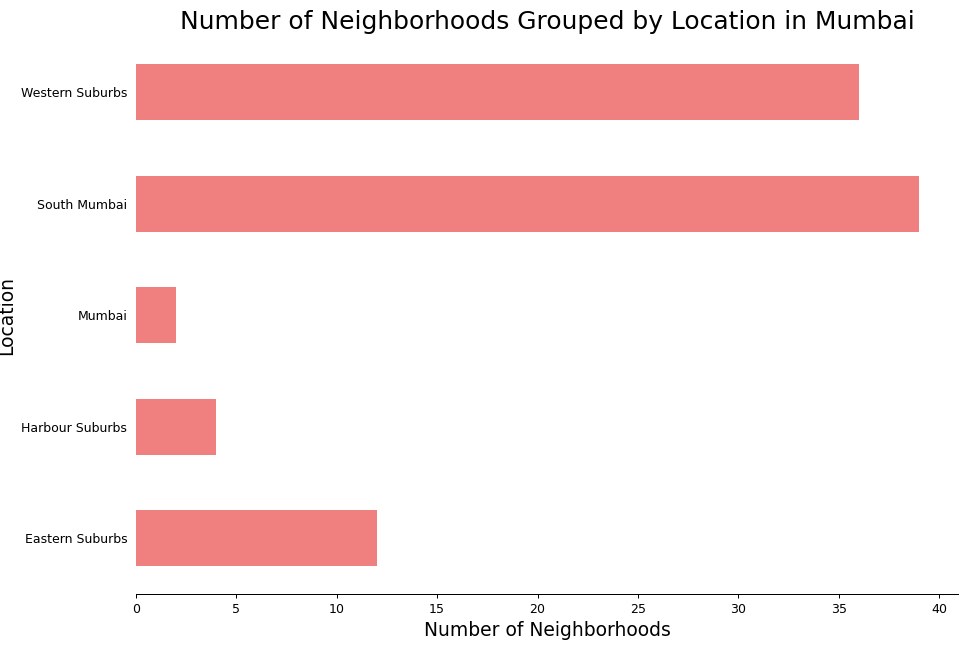

In [13]:
fig = plt.figure(figsize=(12,8))

ax = neighborhoods_mumbai.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Neighborhoods Grouped by Location in Mumbai', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

Clearly we can see that South Mumbai and Western Suburbs have the most number of neighborhoods. Notice how we see one of the locations as Mumbai itself? This is because the neighborhoods contained in this location are located at the outskirts of Mumbai and thus have been grouped as just Mumbai.

Now lets visualize the neighborhoods on a map using Folium. First we will obtain the geographical coordinates of Mumbai using GeoPy.

In [14]:
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

### Using Foursquare API

Now we can start working with the Foursquare API to obtain venue recommendations.

In [15]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Amboli and it's geographical coordinates are 19.1293 latitude and 72.84644000000003 longitude


Lets create the Foursquare credentials first.

In [16]:
# define Foursquare Credentials and Version
CLIENT_ID = 'CPW3BYE0AHWLF5PWGTPDWEZEZOQ5GA2KL4DMBUSUW04HQGC2' # your Foursquare ID
CLIENT_SECRET = 'IEQ2HT4AE3AA4P1WQQMGB0HVK15JSI5S333CJUUUL3YCL0SJ' # your Foursquare Secret
VERSION = '20210706' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CPW3BYE0AHWLF5PWGTPDWEZEZOQ5GA2KL4DMBUSUW04HQGC2
CLIENT_SECRET:IEQ2HT4AE3AA4P1WQQMGB0HVK15JSI5S333CJUUUL3YCL0SJ


We will now extract the top 200 venues near Amboli with a radius of 1000m or 1km. In order to do this, we will start by creating a url.

In [17]:
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

We can now use the GET method to get our results.

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61378956b8b21778e608af24'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jogeshwari West',
  'headerFullLocation': 'Jogeshwari West, Mumbai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 31,
  'suggestedBounds': {'ne': {'lat': 19.13830000900001,
    'lng': 72.85594823590122},
   'sw': {'lat': 19.120299990999992, 'lng': 72.83693176409884}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d10d39b7177b1f7d2c75322',
       'name': 'Cafe Arfa',
       'location': {'address': 'S V Road',
        'crossStreet': 'Andheri West',
        'lat': 19.12893009094341,
        'lng': 72.84714004510111,
        'labeledLatLngs': [{'label'

We will now create a function get_category_type to extract the categories of venues.

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


Now we can clean the JSON obtained using the GET method and store our results in a dataframe.

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-20-dc733077f29a>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


,name,categories,lat,lng
0,Cafe Arfa,Indian Restaurant,19.128930,72.847140
1,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
2,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,19.137714,72.845909
3,Narayan Sandwich,Sandwich Place,19.121398,72.850270
4,Shawarma Factory,Falafel Restaurant,19.124591,72.840398


We can check how many venues were returned by Foursquare.

In [21]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

31 venues were returned for Amboli by Foursquare


### Generalizing Foursquare API

Now that we have seen how the API call works and how we can clean our data to get relevant information, we can generalize this procedure to get nearby venues for all neighborhoods by creating the function getNearbyVenues.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####  We can apply the function created to get nearby venues for all neighborhoods in Mumbai. We will get 200 nearby venues within a 1km radius, same as before.



In [23]:
mum_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Amboli
Chakala
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Uttan
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Dahisar
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Naigaon
Nalasopara
Virar
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Indian Institute of Technology Bombay campus
Vidyavihar
Vikhroli
Chembur
Deonar
Mankhurd
Mahul
Agripada
Altamount Road
Bhuleshwar
Breach Candy
Carmichael Road
Cavel
Churchgate
Cotton Green
Cuffe Parade
Cumbala Hill
Currey Road
Dhobitalao
Dongri
Kala Ghoda
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Malabar Hill
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
C.G.S. colony
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Chira Bazaar
Fanas Wadi
Chor Bazaar
Matunga
Parel
Gowalia Tank
Dava Baza



Lets see what our dataframe looks like.

In [24]:
print(mum_venues.shape)
mum_venues.head(10)

(3684, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.84644,Cafe Arfa,19.128930,72.847140,Indian Restaurant
1,Amboli,19.1293,72.84644,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
2,Amboli,19.1293,72.84644,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
3,Amboli,19.1293,72.84644,Narayan Sandwich,19.121398,72.850270,Sandwich Place
4,Amboli,19.1293,72.84644,Shawarma Factory,19.124591,72.840398,Falafel Restaurant
5,Amboli,19.1293,72.84644,Persia Darbar,19.136952,72.846822,Indian Restaurant
6,Amboli,19.1293,72.84644,Domino's Pizza,19.131000,72.848000,Pizza Place
7,Amboli,19.1293,72.84644,Courtyard Restaurant & Bar,19.131692,72.837269,Asian Restaurant
8,Amboli,19.1293,72.84644,Garden Court,19.127188,72.837478,Indian Restaurant
9,Amboli,19.1293,72.84644,Subway,19.127860,72.844461,Sandwich Place


Lets see how many venues were returned for each neighborhood.

In [25]:
mum_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,11,11,11,11,11,11
1,Agripada,30,30,30,30,30,30
2,Altamount Road,67,67,67,67,67,67
3,Amboli,31,31,31,31,31,31
4,Amrut Nagar,16,16,16,16,16,16
...,...,...,...,...,...,...,...
88,Vikhroli,10,10,10,10,10,10
89,Vile Parle,73,73,73,73,73,73
90,Virar,12,12,12,12,12,12
91,Walkeshwar,10,10,10,10,10,10


We can now check how many unique categories are there in our data.

In [26]:
print("There are {} unique categories".format(mum_venues['Venue Category'].nunique()))

There are 223 unique categories


### Analyzing each neighborhood

We can start analyzing each neighborhood by One-hot Encoding to see which categories belong in which neighborhoods.

In [27]:
mum_onehot = pd.get_dummies(mum_venues[['Venue Category']], prefix="", prefix_sep="")
mum_onehot.head()

,Accessories Store,Advertising Agency,Airport,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Train,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0




Adding Neighborhood column to the one-hot encoded dataframe.

In [28]:
mum_onehot['Neighborhood'] = mum_venues['Neighborhood']
mum_onehot.head()

,Accessories Store,Advertising Agency,Airport,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Train,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Moving the Neighborhood column to the first column.

In [29]:
temp = list(mum_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
mum_onehot = mum_onehot[fixed_columns]

mum_onehot.head()

,Neighborhood,Accessories Store,Advertising Agency,Airport,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,...,Train,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Now we can groupby neighborhood and take the mean for all categories.

In [30]:
mum_grouped = mum_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(mum_grouped.shape)
mum_grouped.head(10)

(93, 223)


,Neighborhood,Accessories Store,Advertising Agency,Airport,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,...,Train,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Amboli,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.032258,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Chakala,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.045455,0.0,0.0,0.0,0.000000,0.0,0.0
2,D.N. Nagar,0.020408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.020408,0.0,0.040816,0.0,0.0,0.0,0.040816,0.0,0.0
3,Four Bungalows,0.015152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.015152,0.0,0.030303,0.0,0.0,0.0,0.015152,0.0,0.0
4,Lokhandwala,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.010753,0.0,0.0,0.0,0.010753,0.0,0.0
5,Marol,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
6,Sahar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.023256,0.0,0.0,0.0,0.000000,0.0,0.0
7,Seven Bungalows,0.016393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.032787,0.0,0.0,0.0,0.016393,0.0,0.0
8,Versova,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9,Mira Road,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.050000,0.0,0.0,0.0,0.000000,0.0,0.0



In order to further understand the data, we can display the top 5 venues of all neighborhoods.

In [31]:
num_top_venues = 5

for hood in mum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mum_grouped[mum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amboli----
               venue  freq
0  Indian Restaurant  0.16
1   Asian Restaurant  0.06
2        Coffee Shop  0.06
3     Sandwich Place  0.06
4                Bar  0.06


----Chakala----
                  venue  freq
0                 Hotel  0.18
1     Indian Restaurant  0.16
2                  Café  0.09
3  Fast Food Restaurant  0.07
4      Asian Restaurant  0.05


----D.N. Nagar----
                  venue  freq
0                   Bar  0.12
1     Indian Restaurant  0.08
2                   Pub  0.08
3           Pizza Place  0.06
4  Gym / Fitness Center  0.06


----Four Bungalows----
                venue  freq
0  Chinese Restaurant  0.06
1                 Pub  0.06
2   Indian Restaurant  0.06
3                Café  0.06
4  Seafood Restaurant  0.05


----Lokhandwala----
                  venue  freq
0     Indian Restaurant  0.12
1    Chinese Restaurant  0.06
2                  Café  0.06
3  Gym / Fitness Center  0.04
4                   Pub  0.04


----Marol----
             

                  venue  freq
0                 Plaza  0.29
1             Multiplex  0.14
2           Pizza Place  0.14
3         Train Station  0.14
4  Fast Food Restaurant  0.14


----Cuffe Parade----
                venue  freq
0   Indian Restaurant  0.14
1                 Spa  0.10
2         Coffee Shop  0.10
3  Italian Restaurant  0.10
4                 Gym  0.05


----Cumbala Hill----
                  venue  freq
0                Bakery  0.06
1     Indian Restaurant  0.06
2  Fast Food Restaurant  0.06
3                   Bar  0.06
4    Chinese Restaurant  0.04


----Currey Road----
                venue  freq
0   Indian Restaurant  0.12
1                Café  0.08
2         Coffee Shop  0.06
3  Seafood Restaurant  0.04
4              Lounge  0.04


----Dhobitalao----
               venue  freq
0  Indian Restaurant  0.18
1               Café  0.07
2        Coffee Shop  0.05
3      Train Station  0.05
4                Bar  0.05


----Dongri----
                venue  freq
0   Indi

Lets now create a dataframe with the top 10 common venues for each neighborhood

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Indian Restaurant,Sandwich Place,Gym,Bar,Bakery,Pizza Place,Asian Restaurant,Coffee Shop,Tea Room,Bowling Alley
1,Chakala,Hotel,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Restaurant,Multiplex,Asian Restaurant,Bar,Hotel Bar
2,D.N. Nagar,Bar,Indian Restaurant,Pub,Pizza Place,Gym / Fitness Center,Snack Place,Women's Store,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant
3,Four Bungalows,Indian Restaurant,Café,Pub,Chinese Restaurant,Ice Cream Shop,Seafood Restaurant,Bar,Vegetarian / Vegan Restaurant,Pizza Place,Lounge
4,Lokhandwala,Indian Restaurant,Café,Chinese Restaurant,Pub,Gym / Fitness Center,Bar,Bakery,Coffee Shop,Italian Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,Indian Restaurant,Coffee Shop,Chinese Restaurant,Bar,Pharmacy,Multicuisine Indian Restaurant,Playground,Plaza,Clothing Store,Bus Station
89,Gowalia Tank,Indian Restaurant,Bakery,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Ice Cream Shop,Snack Place,Sandwich Place,Theater
90,Dava Bazaar,Train Station,Track Stadium,Cupcake Shop,Café,Fish Market,Asian Restaurant,Theme Park,Beer Garden,Indian Restaurant,Restaurant
91,Dharavi,Café,Indian Restaurant,Hookah Bar,Garden,Bus Station,Sandwich Place,Seafood Restaurant,Shoe Store,Fast Food Restaurant,Snack Place


### Clustering neighborhoods


Now we can use KMeans clustering method to cluster the neighborhoods.

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

We will define a function to plot the Silhouette Score that will be calculated using different number of clusters.

In [34]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [35]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = mum_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

We can now display the scores for different number of clusters and plot the data as well.

[0.09631011344013526, 0.31383368286335844, 0.08065535006178642, 0.08859235989958923, 0.09407646386586326, 0.08706761903089623, 0.0948249790330584, 0.10059321995820476, 0.10687792142382552, 0.0787242881850182, 0.06889601435789094, 0.06649951415079607, 0.06881981886964045, 0.05587919457988961]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


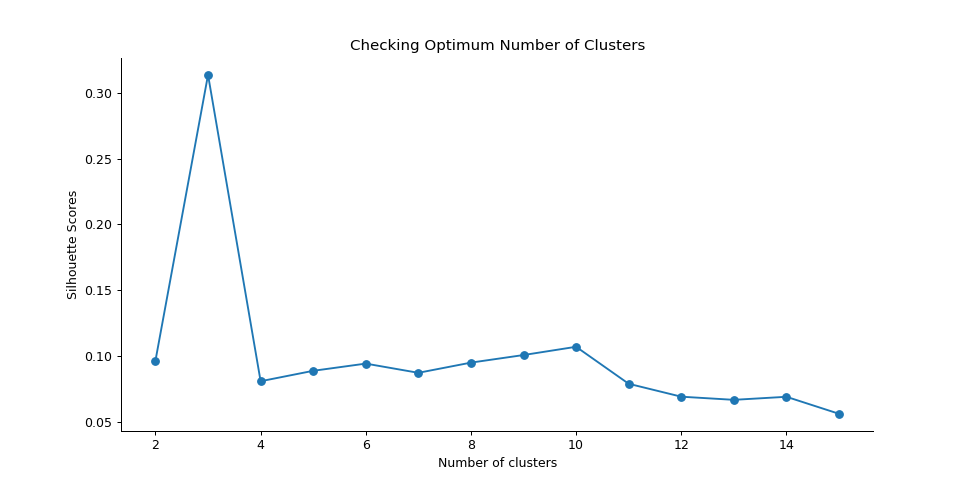

In [36]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not very high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. However, we will try to cluster our data as best as we can. For this, we will use 5 clusters for our clustering model since it provides the highest silhouette score as seen above.



In [37]:
k = 5

mum_clustering = mum_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(mum_clustering) #Can choose any random_state

kmeans.labels_

array([1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1,
       3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 0, 0, 3, 1, 0, 3, 1, 1,
       1, 1, 1, 1, 1, 3, 4, 1, 1, 3, 1, 3, 3, 1, 1, 0, 1, 3, 3, 1, 1, 3,
       3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 0, 4, 3, 1, 1, 1, 1, 1, 1,
       1, 3, 0, 3, 2])

Now we can create a new dataframe that includes cluster labels and the top 10 venues.

In [38]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
mum_merged = df
mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lets view the newly created dataframe.

In [39]:
print(mum_merged.shape)
mum_merged

(93, 15)


,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.1293,72.8464,1,Indian Restaurant,Sandwich Place,Gym,Bar,Bakery,Pizza Place,Asian Restaurant,Coffee Shop,Tea Room,Bowling Alley
1,Chakala,Western Suburbs,19.1084,72.8623,1,Hotel,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Restaurant,Multiplex,Asian Restaurant,Bar,Hotel Bar
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,3,Bar,Indian Restaurant,Pub,Pizza Place,Gym / Fitness Center,Snack Place,Women's Store,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant
3,Four Bungalows,Western Suburbs,19.1264,72.8242,3,Indian Restaurant,Café,Pub,Chinese Restaurant,Ice Cream Shop,Seafood Restaurant,Bar,Vegetarian / Vegan Restaurant,Pizza Place,Lounge
4,Lokhandwala,Western Suburbs,19.1432,72.825,3,Indian Restaurant,Café,Chinese Restaurant,Pub,Gym / Fitness Center,Bar,Bakery,Coffee Shop,Italian Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.9957,72.84,1,Indian Restaurant,Coffee Shop,Chinese Restaurant,Bar,Pharmacy,Multicuisine Indian Restaurant,Playground,Plaza,Clothing Store,Bus Station
89,Gowalia Tank,South Mumbai,18.9645,72.8112,3,Indian Restaurant,Bakery,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Ice Cream Shop,Snack Place,Sandwich Place,Theater
90,Dava Bazaar,South Mumbai,19.1314,72.927,0,Train Station,Track Stadium,Cupcake Shop,Café,Fish Market,Asian Restaurant,Theme Park,Beer Garden,Indian Restaurant,Restaurant
91,Dharavi,Mumbai,19.0467,72.8546,3,Café,Indian Restaurant,Hookah Bar,Garden,Bus Station,Sandwich Place,Seafood Restaurant,Shoe Store,Fast Food Restaurant,Snack Place


We can now view the neighborhoods in each cluster and their top 10 most common venues.

### Cluster 1

In [40]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bhayandar,Western Suburbs,Ice Cream Shop,Soccer Field,Bakery,Food Truck,Indian Restaurant,Restaurant,Train Station,Diner,Pizza Place,Falafel Restaurant
32,Nalasopara,Western Suburbs,Multiplex,Ice Cream Shop,Pizza Place,Platform,Fast Food Restaurant,Department Store,Diner,Dim Sum Restaurant,Field,Farmers Market
36,Bhandup,Eastern Suburbs,Train Station,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Zoo,Diner,Fish Market,Fish & Chips Shop,Field,Farmers Market
37,Amrut Nagar,Eastern Suburbs,Indian Restaurant,Ice Cream Shop,Train Station,Café,Mughlai Restaurant,Smoke Shop,Multiplex,Plaza,Bus Station,Hotel
40,Kanjurmarg,Eastern Suburbs,Train Station,Multiplex,Asian Restaurant,Gym,Hotel,Ice Cream Shop,Theme Park,Cupcake Shop,Gift Shop,Diner
59,Cotton Green,South Mumbai,Plaza,Pizza Place,Fast Food Restaurant,Train Station,Bakery,Multiplex,Dim Sum Restaurant,Field,Farmers Market,Falafel Restaurant
79,C.G.S. colony,South Mumbai,Indian Restaurant,Multiplex,Train Station,Tea Room,Ice Cream Shop,Sports Bar,Café,Big Box Store,Pizza Place,Theater
90,Dava Bazaar,South Mumbai,Train Station,Track Stadium,Cupcake Shop,Café,Fish Market,Asian Restaurant,Theme Park,Beer Garden,Indian Restaurant,Restaurant


### Cluster 2

In [41]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,Indian Restaurant,Sandwich Place,Gym,Bar,Bakery,Pizza Place,Asian Restaurant,Coffee Shop,Tea Room,Bowling Alley
1,Chakala,Western Suburbs,Hotel,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Restaurant,Multiplex,Asian Restaurant,Bar,Hotel Bar
5,Marol,Western Suburbs,Indian Restaurant,Hotel,Coffee Shop,Chinese Restaurant,Lounge,Diner,Restaurant,Ice Cream Shop,Farmers Market,Fast Food Restaurant
9,Mira Road,Western Suburbs,Indian Restaurant,Restaurant,Convenience Store,Shopping Mall,Market,Mexican Restaurant,Sporting Goods Shop,Food Truck,Bar,Multiplex
11,Uttan,Western Suburbs,Convenience Store,Whisky Bar,Indian Restaurant,Restaurant,Zoo,Dim Sum Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
13,Kherwadi,Western Suburbs,Indian Restaurant,Café,Hookah Bar,Seafood Restaurant,Italian Restaurant,Restaurant,Bar,Multiplex,Pub,Chinese Restaurant
15,I.C. Colony,Western Suburbs,Indian Restaurant,Soccer Field,Coffee Shop,Chinese Restaurant,Fast Food Restaurant,Bar,Auto Workshop,Park,Pizza Place,Department Store
20,Jogeshwari West,Western Suburbs,Indian Restaurant,Mughlai Restaurant,Men's Store,Bus Station,Bakery,Café,Smoke Shop,Chinese Restaurant,Asian Restaurant,Snack Place
21,Juhu,Western Suburbs,Indian Restaurant,Coffee Shop,Restaurant,Movie Theater,Vegetarian / Vegan Restaurant,Café,Fast Food Restaurant,Shopping Mall,Lounge,Convention Center
23,Poisar,Western Suburbs,Indian Restaurant,Train Station,Gym / Fitness Center,Platform,Dessert Shop,Electronics Store,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant,Snack Place


### Cluster 3

In [42]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Thane,Mumbai,Pizza Place,Performing Arts Venue,Dim Sum Restaurant,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory,Event Space


### Cluster 4

In [43]:
mum_merged.loc[mum_merged['Cluster Labels'] == 3, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,D.N. Nagar,Western Suburbs,Bar,Indian Restaurant,Pub,Pizza Place,Gym / Fitness Center,Snack Place,Women's Store,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant
3,Four Bungalows,Western Suburbs,Indian Restaurant,Café,Pub,Chinese Restaurant,Ice Cream Shop,Seafood Restaurant,Bar,Vegetarian / Vegan Restaurant,Pizza Place,Lounge
4,Lokhandwala,Western Suburbs,Indian Restaurant,Café,Chinese Restaurant,Pub,Gym / Fitness Center,Bar,Bakery,Coffee Shop,Italian Restaurant,Seafood Restaurant
6,Sahar,Western Suburbs,Indian Restaurant,Café,Hotel,Restaurant,Asian Restaurant,Multiplex,Gym,Pizza Place,Fast Food Restaurant,Seafood Restaurant
7,Seven Bungalows,Western Suburbs,Café,Indian Restaurant,Bar,Pub,Ice Cream Shop,Pizza Place,Seafood Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop
8,Versova,Western Suburbs,Café,Ice Cream Shop,Beach,Clothing Store,Coffee Shop,Chinese Restaurant,Restaurant,Bistro,Recreation Center,Diner
12,Bandstand Promenade,Western Suburbs,Coffee Shop,Café,Performing Arts Venue,Indian Restaurant,Scenic Lookout,Deli / Bodega,Tea Room,Fast Food Restaurant,Department Store,Lounge
14,Pali Hill,Western Suburbs,Bakery,Indian Restaurant,Café,Fast Food Restaurant,Dessert Shop,Bar,Asian Restaurant,Italian Restaurant,Ice Cream Shop,Chinese Restaurant
16,Gorai,Western Suburbs,Food,Seafood Restaurant,Beach,Scenic Lookout,Resort,Rest Area,Zoo,Dim Sum Restaurant,Farmers Market,Falafel Restaurant
17,Dahisar,Western Suburbs,Bar,Juice Bar,Chinese Restaurant,Café,Indian Restaurant,Fish Market,Pizza Place,Bakery,Restaurant,Department Store


### Cluster 5

In [44]:
mum_merged.loc[mum_merged['Cluster Labels'] == 4, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Mankhurd,Harbour Suburbs,Bus Station,Coffee Shop,Sports Bar,Train Station,Zoo,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
80,Dagdi Chawl,South Mumbai,Bus Station,Harbor / Marina,Coffee Shop,Train Station,Bakery,Zoo,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market


Comparing clusters 1 and 2, neighborhoods in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of food joints in the top 10 most common venues than cluster 2. The neighborhoods in cluster 1 contain a variety of food joints like restaurants, tea rooms, bakery, cafe, steakhouse and pubs and also contain very diverse cuisines like Japanese, Indian, Chinese, Italian and seafood restaurants. Most neighborhoods in cluster 2 seem to have Indian Restaurant as their top most common venue; however, on careful analysis we can see that neighborhoods in cluster 2 also contain other venues like soccer field, flea market, smoke shop, gym, train station, dance studio, music store, cosmetics shop and so on. Thus, it is recommended that the new restaurant can be opened in the neighborhoods belonging to cluster 1. This neighborhood can be further plotted on a map as shown below.

In [45]:
new_restaurant_neighborhoods = mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0, 1, 2, 3] + list(range(5, mum_merged.shape[1]))]]
new_restaurant_neighborhoods.head()

,Neighborhood,Location,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bhayandar,Western Suburbs,19.3074,72.8518,Ice Cream Shop,Soccer Field,Bakery,Food Truck,Indian Restaurant,Restaurant,Train Station,Diner,Pizza Place,Falafel Restaurant
32,Nalasopara,Western Suburbs,19.42,72.8141,Multiplex,Ice Cream Shop,Pizza Place,Platform,Fast Food Restaurant,Department Store,Diner,Dim Sum Restaurant,Field,Farmers Market
36,Bhandup,Eastern Suburbs,19.1456,72.9486,Train Station,Fast Food Restaurant,Indian Restaurant,Asian Restaurant,Zoo,Diner,Fish Market,Fish & Chips Shop,Field,Farmers Market
37,Amrut Nagar,Eastern Suburbs,19.1452,72.8467,Indian Restaurant,Ice Cream Shop,Train Station,Café,Mughlai Restaurant,Smoke Shop,Multiplex,Plaza,Bus Station,Hotel
40,Kanjurmarg,Eastern Suburbs,19.1315,72.9357,Train Station,Multiplex,Asian Restaurant,Gym,Hotel,Ice Cream Shop,Theme Park,Cupcake Shop,Gift Shop,Diner


In [46]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['Location'], new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred')).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations